В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import roc_auc_score, confusion_matrix, root_mean_squared_error
import joblib
from matplotlib import pyplot as plt
import seaborn as sns

Area under ROC score on Train dataset: 0.83%


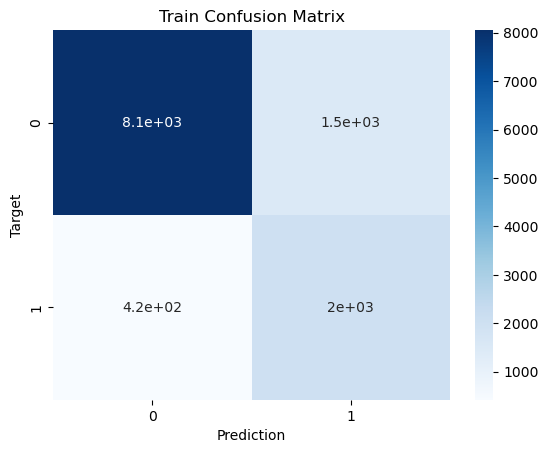

Area under ROC score on Validation dataset: 0.81%


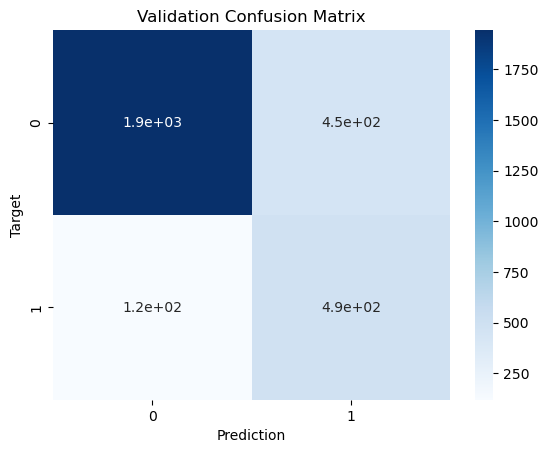

['model_pipeline.pkl']

In [4]:
raw_df = pd.read_csv("https://docs.google.com/spreadsheets/d/11uG3Rk3uaw-RLfTY-dkWST3EdSvhpNQipIu6PylnWBM/gviz/tq?tqx=out:csv&sheet=Sheet1", index_col=0)
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df["Exited"])

# Створюємо трен. і вал. набори
input_cols = train_df.drop(columns=["Exited"]).columns.tolist()
target_col = "Exited"
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_inputs.select_dtypes(exclude=[np.number]).columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'model_pipeline.pkl')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train with Polynomial Features dataset: 0.87%


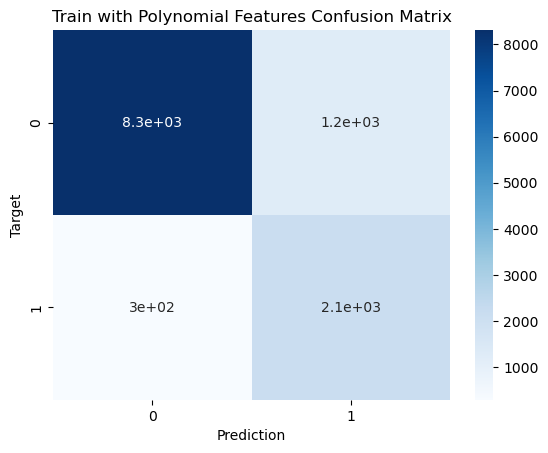

Area under ROC score on Validation with Polynomial Features dataset: 0.86%


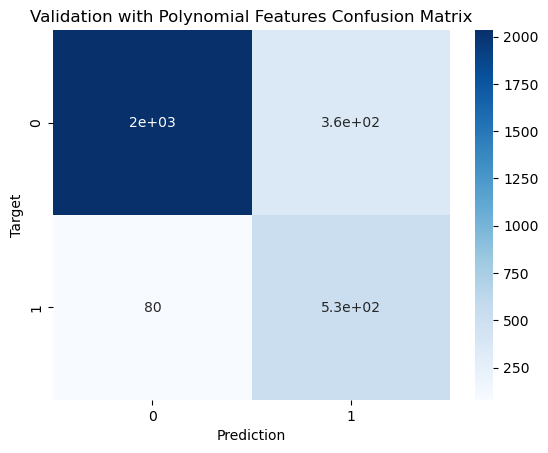

['model_pipeline_poly_2.pkl']

In [ ]:
numeric_transformer_poly_2 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_2),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

model_pipeline_poly_2.fit(train_inputs, train_targets)

train_preds_poly = predict_and_plot(model_pipeline_poly_2, train_inputs, train_targets, name='Train with Polynomial Features')
val_preds_poly = predict_and_plot(model_pipeline_poly_2, val_inputs, val_targets, name='Validation with Polynomial Features')

joblib.dump(model_pipeline_poly_2, 'model_pipeline_poly_2.pkl')

Поліномінальна модель з другим степенем полінома показала кращі результати на валідаційних даних, ніж модель без поліномів.
Це свідчить про те, що деякі взаємодії між ознаками можуть бути важливими для передбачення цільової змінної.
ROC на валідаційних даних для моделі з поліномами виявився вищим, ніж для базової моделі, що підтверджує цю гіпотезу (0,86 проти 0,81).
Порівнюючи поліноміальну модель з базовою, ми бачимо, що вона краще справляється з виявленням позитивних випадків (Exited = 1), що може бути важливим для бізнесу, оскільки дозволяє краще ідентифікувати клієнтів, які можуть залишити компанію.


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train with Polynomial Features Degree 4 dataset: 0.88%


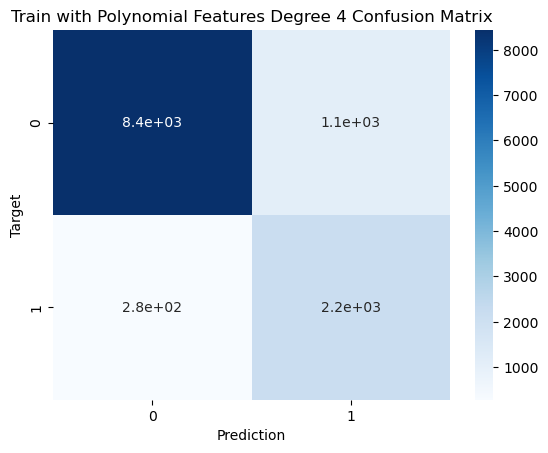

Area under ROC score on Validation with Polynomial Features Degree 4 dataset: 0.86%


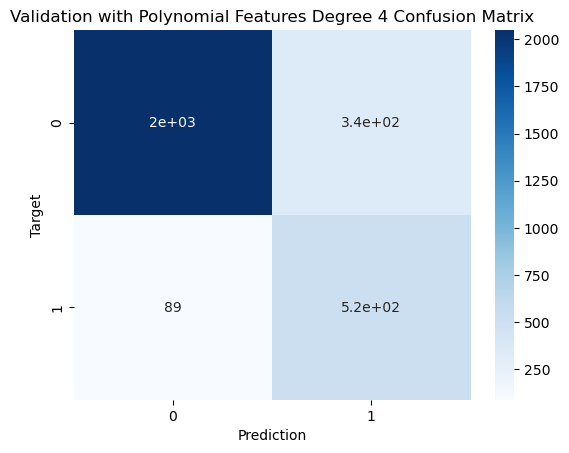

['model_pipeline_poly_4.pkl']

In [6]:
numeric_transformer_poly_4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())
])


preprocessor_poly_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_4),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

model_pipeline_poly_4.fit(train_inputs, train_targets)

train_preds_poly_4 = predict_and_plot(model_pipeline_poly_4, train_inputs, train_targets, name='Train with Polynomial Features Degree 4')
val_preds_poly_4 = predict_and_plot(model_pipeline_poly_4, val_inputs, val_targets, name='Validation with Polynomial Features Degree 4')

joblib.dump(model_pipeline_poly_4, 'model_pipeline_poly_4.pkl')

Полінноміальна модель з 4 степенем має кращі результати на тренувальних даних порівняно з моделлю з 2 степенем 
але на валідаційних даних результати однакові. Це може свідчити про перенавчання моделі з 4 степенем, 
оскільки вона може бути занадто складною для даних. 
Модель з 2 степенем показує кращий баланс між точністю та узагальненням на валідаційних даних.

In [62]:
test_raw_data = pd.read_csv("https://docs.google.com/spreadsheets/d/1oRLDSQ8Mlc0nq_mTS7ffBFWij7WMGu5lh1-5H5abBWc/gviz/tq?tqx=out:csv&sheet=Test")
test_raw_data = test_raw_data.drop(columns=['Exited'], errors='ignore')
prob = model_pipeline_poly_2.predict_proba(test_raw_data)[:,1]
test_raw_data['Exited'] = prob
submission_df = pd.DataFrame({
    'id': test_raw_data.id,
    'Exited': test_raw_data['Exited']
})
submission_df.to_csv('submission_poly_2.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [28]:
def train_poly_linear_model(model, degree, df, target_col=''):
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    input_cols = train_df.drop(columns=[target_col]).columns.tolist()

    train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
    val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

    numeric_cols = train_inputs.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = train_inputs.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_transformer_poly = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    transformers = [('num', numeric_transformer_poly, numeric_cols)]
    if categorical_cols:
        transformers.append(('cat', categorical_transformer, categorical_cols))

    preprocessor_poly = ColumnTransformer(transformers=transformers)

    model_pipeline_poly = Pipeline(steps=[
        ('preprocessor', preprocessor_poly),
        ('regressor', model)
    ])

    model_pipeline_poly.fit(train_inputs, train_targets)
    return model_pipeline_poly, train_inputs, train_targets, val_inputs, val_targets, model.__class__.__name__


def train_test_results(model, X_train, y_train, X_test, y_test, model_name=''):
    predictions_train = model.predict(X_train)
    loss_train = root_mean_squared_error(y_train, predictions_train)
    print(f"Train RMSE: {loss_train:.2f}")

    predictions_test = model.predict(X_test)
    loss_test = root_mean_squared_error(y_test, predictions_test)
    print(f"Validation RMSE: {loss_test:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(1, 2, 1)
    plt.scatter(y_train, predictions_train, alpha=0.5)
    plt.xlabel("True Train")
    plt.ylabel("Predicted Train")
    plt.title(f"{model_name} Train: Real vs Predicted")
    plt.plot(1, 2, 2)
    plt.scatter(y_test, predictions_test, alpha=0.5, color='orange')
    plt.xlabel("True Validation")
    plt.ylabel("Predicted Validation")
    plt.title(f"{model_name} Validation: Real vs Predicted")
    plt.legend(['Train', 'Validation'])
    plt.show()

    return predictions_train, predictions_test



Train RMSE: 0.00
Validation RMSE: 13.70


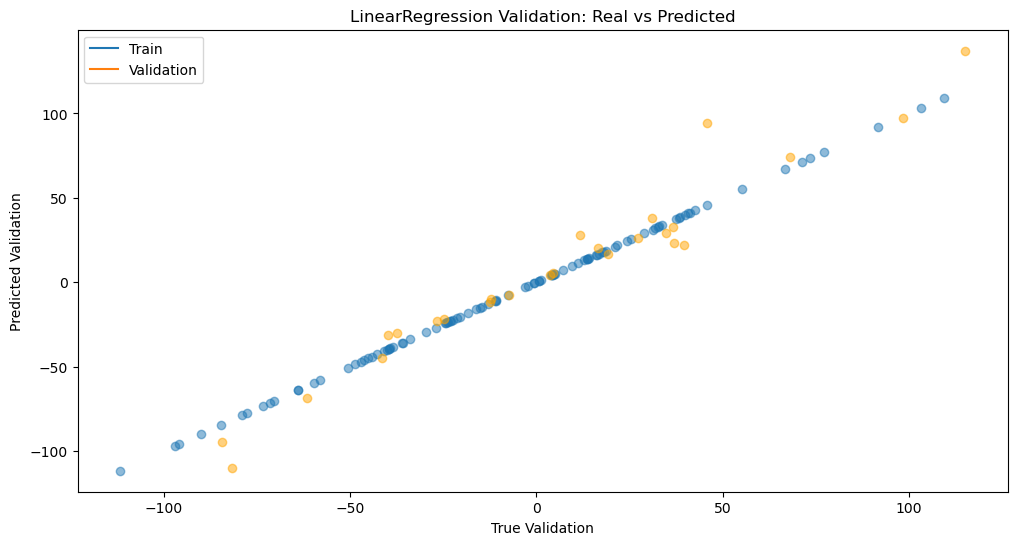

In [31]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/1gNRh4Ahb3zVzgmu-wDcWNIfcTBDXsFPhsI3DjsT3KLc/gviz/tq?tqx=out:csv&sheet=Sheet1")
degree = 5
target_col = 'target'
model = LinearRegression()

model_pipeline_poly, train_inputs, train_targets, val_inputs, val_targets, model_name = train_poly_linear_model(model, degree, df, target_col)
train_preds_poly, val_preds_poly = train_test_results(model_pipeline_poly, train_inputs, train_targets, val_inputs, val_targets, model_name)

Висновок:

Згідно результатів RMSE на тренувальній вибірці дорівнює 0, тобто модель ідеально підлаштувалась під тренувальні дані. На валідаційній вибірці RMSE складає 13.70, що свідчить про значно гірше узагальнення на нових даних, що вказує на перенавчання моделі (overfitting), Графік також показує відмінності між передбаченнями та справжніми значеннями для валідаційних даних, хоча загалом модель досить точно слідує діагоналі. Це означає, що модель сильно підлаштувалась під тренувальні дані, але має втрату якості на валідаційних — варто розглянути зниження ступеня полінома.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

Training model: Lasso with polynomial degree 20
Train RMSE: 1.48
Validation RMSE: 1.39


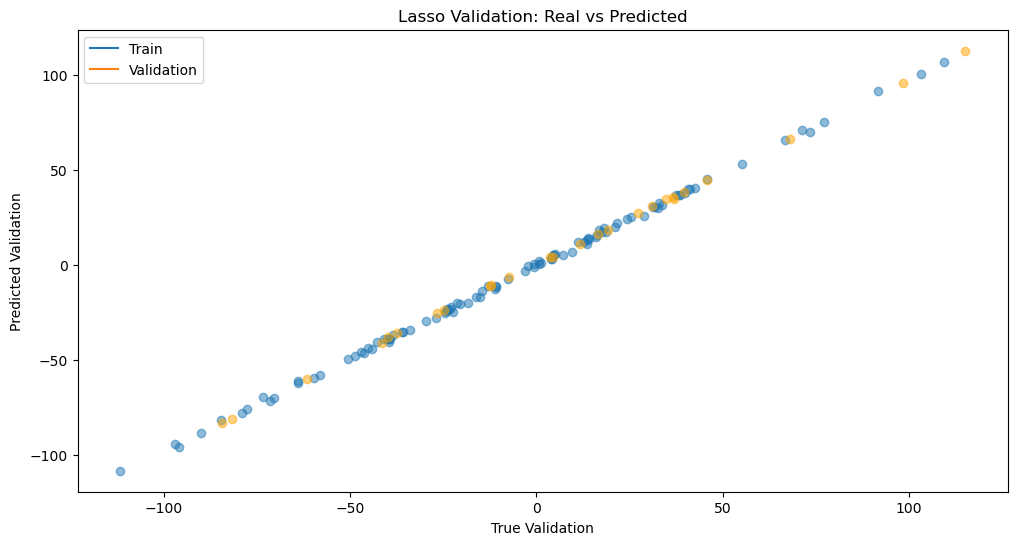

Training model: Ridge with polynomial degree 20
Train RMSE: 1.05
Validation RMSE: 27.80


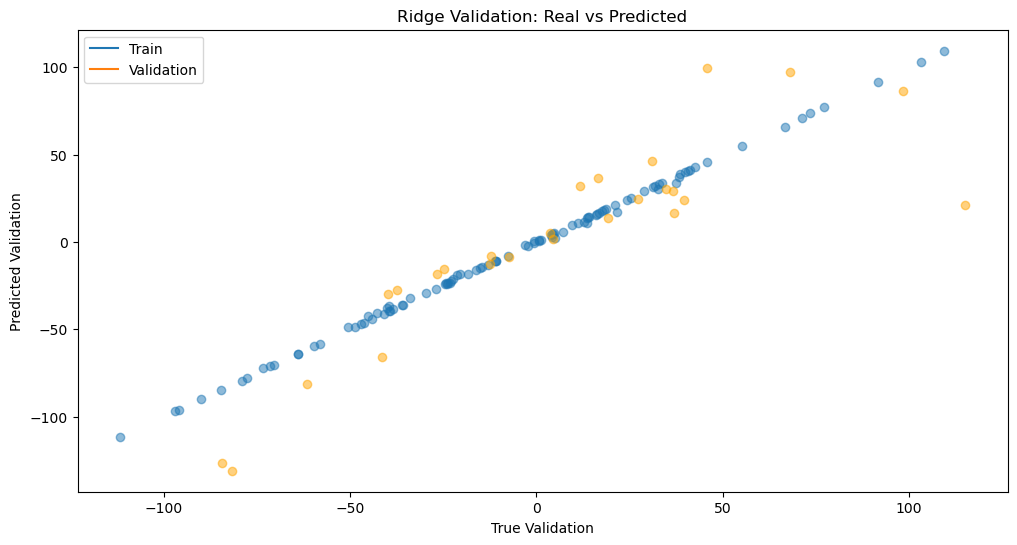

Training model: ElasticNet with polynomial degree 20
Train RMSE: 12.04
Validation RMSE: 20.62


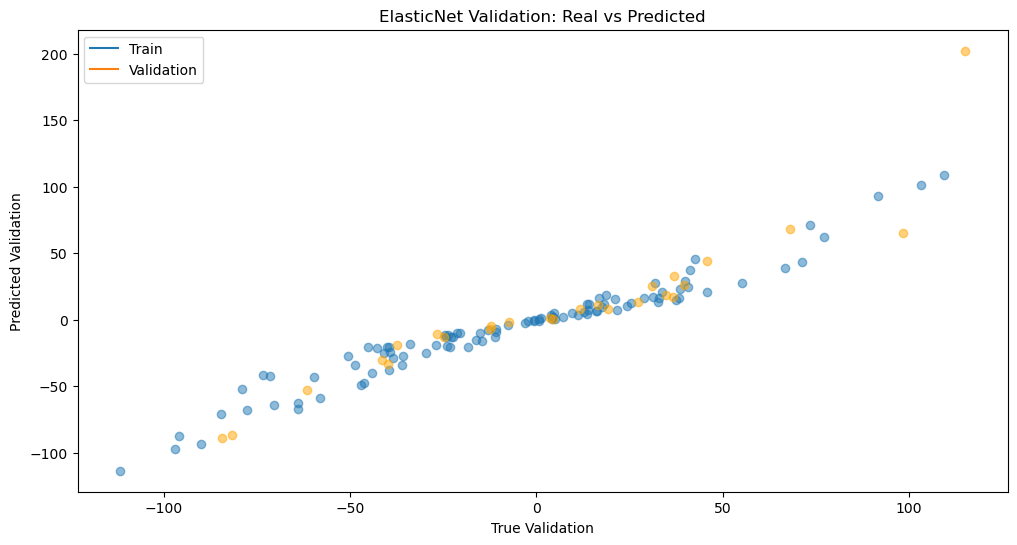

In [45]:
models = [
  Lasso(),
  Ridge(),
  ElasticNet()
]

degree = 20

for model in models:
  print(f"Training model: {model.__class__.__name__} with polynomial degree {degree}")
  model_pipeline_poly, train_inputs, train_targets, val_inputs, val_targets, model_name = train_poly_linear_model(model, degree, df, target_col)
  train_preds_poly, val_preds_poly = train_test_results(model_pipeline_poly, train_inputs, train_targets, val_inputs, val_targets, model_name)

Висновок:

Серед моделей із поліноміальними ознаками 20-го степеня, Lasso показала найкращу генералізацію — RMSE на тренувальних(1.48) та валідаційних даних (1.39) близькі, без значного перенавчання.
Ridge та ElasticNet мають менший RMSE на тренуванні, але вищий на валідації (особливо Ridge), що вказує на перенавчання або недооптимальні параметри регуляризації, які потрібують більшого дослідження для покращення.
Lasso найкраще відсікла зайві ознаки, що допомогло знизити ризик перенавчання при великій кількості поліноміальних ознак.